# Final project

In [ ]:
!pip install transformers
!pip install preprocess

In [ ]:
import os
import os.path
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import warnings
import joblib
import json
import csv
import random
import itertools
import matplotlib.pyplot as plt

from pathlib import Path
from google.colab import data_table
from statistics import mean
from transformers import DistilBertModel, AdamW, logging, BertTokenizer, DistilBertTokenizerFast, BertForSequenceClassification ,get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, random_split, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score 
from tqdm import tqdm


In [ ]:
use_multiprocessing=False
logging.set_verbosity_error()
warnings.filterwarnings('ignore')

%load_ext google.colab.data_table
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10

In [ ]:
def create_plot(array1, array2, label1, label2, x_label, y_label, title, epoch = 10):
  epoch_array = list(range(1,epoch+1))
  plt.figure(figsize = (15,7))
  plt.subplot(1, 2, 2)
  plt.plot(epoch_array, array1, label = label1, color = "blue")
  plt.plot(epoch_array, array2, label = label2, color = "red")
  plt.title(title, fontsize = 20, weight='bold')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend(loc = 'upper right')
  plt.grid()
  plt.show()

In [ ]:
def create_plot_one_array(array1, label1, x_label, y_label, title, epoch = 10):
  epoch_array = list(range(1,epoch+1))
  plt.figure(figsize = (15,7))
  plt.subplot(1, 2, 2)
  plt.plot(epoch_array, array1, label = label1, color = "blue")
  plt.title(title, fontsize = 20, weight='bold')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend(loc = 'upper right')
  plt.grid()
  plt.show()

## **Download the SQuAD dataset**

The Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles. 

The answer to every question is a segment of text (a span) from the corresponding reading passage. 

Recently, SQuAD 2.0 has been released, which includes unanswerable questions.

The public leaderboard is available on the SQuAD website.

In [ ]:
!git clone https://github.com/rajpurkar/SQuAD-explorer.git

fatal: destination path 'SQuAD-explorer' already exists and is not an empty directory.


In [ ]:
squad_train_path = "/content/SQuAD-explorer/dataset/train-v2.0.json"
squad_dev_path = "/content/SQuAD-explorer/dataset/dev-v2.0.json"

In [ ]:
def load_data(file_path):
  flattened_data = []

  with open(file_path) as set_file:
    data = json.load(set_file)

    for i, article in enumerate(data["data"]):
      title = article.get("title", "").strip()
      for paragraph in article["paragraphs"]:
        context = paragraph["context"].strip()
        for qa in paragraph["qas"]:
          question = qa["question"].strip()
          id_ = qa["id"]
          impossible = qa["is_impossible"]

          answer_starts = [answer["answer_start"] for answer in qa["answers"]]
          answers = [answer["text"].strip() for answer in qa["answers"]]

          # Features currently used are "context", "question", and "answers".
          # Others are extracted here for the ease of future expansions.
          flattened_data.append({"title": title, "context": context, "question": question, "id": id_, "answer.start": answer_starts, "answer.text": answers, "impossible": impossible})
  
  return flattened_data

In [ ]:
# create datasets
squad_train_dataset = load_data(squad_train_path)
squad_dev_dataset = load_data(squad_dev_path)

# converting json dataset from dictionary to dataframe
squad_train_df = pd.DataFrame.from_dict(squad_train_dataset)
squad_dev_df = pd.DataFrame.from_dict(squad_dev_dataset)

Verify dataset

In [ ]:
squad_train_df.head()

,title,context,question,id,answer.start,answer.text,impossible
0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,56be85543aeaaa14008c9063,[269],[in the late 1990s],False
1,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,56be85543aeaaa14008c9065,[207],[singing and dancing],False
2,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,56be85543aeaaa14008c9066,[526],[2003],False
3,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,56bf6b0f3aeaaa14008c9601,[166],"[Houston, Texas]",False
4,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,56bf6b0f3aeaaa14008c9602,[276],[late 1990s],False


In [ ]:
squad_dev_df.head()

,title,context,question,id,answer.start,answer.text,impossible
0,Normans,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,56ddde6b9a695914005b9628,"[159, 159, 159, 159]","[France, France, France, France]",False
1,Normans,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,56ddde6b9a695914005b9629,"[94, 87, 94, 94]","[10th and 11th centuries, in the 10th and 11th...",False
2,Normans,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,56ddde6b9a695914005b962a,"[256, 256, 256, 256]","[Denmark, Iceland and Norway, Denmark, Iceland...",False
3,Normans,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,56ddde6b9a695914005b962b,"[308, 308, 308, 308]","[Rollo, Rollo, Rollo, Rollo]",False
4,Normans,The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,56ddde6b9a695914005b962c,"[671, 649, 671, 671]","[10th century, the first half of the 10th cent...",False


# **Download the Sentiment140 dataset**
**Sentiment140 dataset with 1.6 million tweets dataset**

This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .


It contains the following 6 fields:

1.   target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
2.   ids: The id of the tweet ( 2087)
3.   date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
4.   flag: The query (lyx). If there is no query, then this value is NO_QUERY.
5.   text: the text of the tweet (Lyx is cool)


In [ ]:
filesSemantic = Path("../content/sentiment140")

if filesSemantic.exists():
  print("Files already loaded")
else:
  # First, let’s install the Kaggle package that will be used for importing the data.
  !pip install kaggle

  # Next, we need to upload the credentials of our Kaggle account. To do so, you need to enter your profile and “Create New API Token”. 
  # If you already have one you can click on “Expire API Token” and create a new one.
  # Then, save the json file with your credentials on your computer and upload this file to Colab using the code below:
  kaggle_file = Path("/content/kaggle.json")
  if kaggle_file.is_file():
    print("kaggle json exist, procceed")
  else:
    from google.colab import files
    files.upload()

  # The Kaggle API client expects the json file to be in ~/.kaggle folder so let’s create a new folder and move it inside.
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  # Next, we will click on the three vertical points on the right side of the screen and “Copy the API Command” of the dataset that we want to import from Kaggle.
  # Than we will paste this line of code in our notebook as below:
  !kaggle datasets download -d kazanova/sentiment140

  # Let’s see the imported files:
  !ls

  # Now, the last step is to open the extracted files and get the data:
  import zipfile
  zip_ref = zipfile.ZipFile('/content/sentiment140.zip', 'r')
  zip_ref.extractall('/content/sentiment140')
  
  zip_ref.close()

  print("Done extract data")

Files already loaded


In [ ]:
DATASET_PATH = "/content/sentiment140/training.1600000.processed.noemoticon.csv"
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
INTERESTING_COLUMNS = ["target", "ids", "text"]
DATASET_ENCODING = "ISO-8859-1"
ALL_FORMAT = "{}_all.csv"
SHORT_FORMAT = "{}_{}.csv"
SENTIMENT_NUM_TO_STRING = {0: "Negative", 4: "Positive"}

In [ ]:
sentimant_df = pd.read_csv(DATASET_PATH, encoding = DATASET_ENCODING, names = DATASET_COLUMNS)

**Verify dataset**

In [ ]:
sentimant_df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
sentimant_df.target.value_counts()

4    800000
0    800000
Name: target, dtype: int64

In [ ]:
sentimant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


## Adjusting the SA to QA
**Split dataset to a dataset of 10000 negative and 10000 positive sentiments**

In [ ]:
def convert_sentiment_data_to_qa_data(data):
  data['question'] = "would you feel positively about " + data['text'] + " ?"
  data = data.rename(columns={'text': 'context', 'target': 'answer'})

  return data[['context', 'question', 'answer']]

def cleanup_from_at_signs(data):
  df1 = data.query('not text.str.contains("@")', engine='python')
  df2 = df1.applymap(lambda x: x.strip() if isinstance(x, str) else x)
  return df2

def create_short_sentiment_file_with_no_mentions(data):
  # clean df
  cleanup_df = cleanup_from_at_signs(data)
  
  # create short df, 10000 of negative sentiments and 10000 of positive sentiments
  grouped = data.groupby(cleanup_df.target)
  negative_short_group = grouped.get_group(0).head(10000)
  positive_short_group = grouped.get_group(4).head(10000)

  # combined 2 df's
  combined_df = pd.concat([negative_short_group, positive_short_group])
  return combined_df

In [ ]:
short_sentimant_df = create_short_sentiment_file_with_no_mentions(sentimant_df)

In [ ]:
short_sentimant_df.head()

,target,ids,date,flag,user,text
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
10,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city... it's snowing
11,0,1467812579,Mon Apr 06 22:20:17 PDT 2009,NO_QUERY,pardonlauren,I just re-pierced my ears


In [ ]:
sentiment_to_qa_df = convert_sentiment_data_to_qa_data(short_sentimant_df)

In [ ]:
sentiment_to_qa_df.head()

,context,question,answer
1,is upset that he can't update his Facebook by ...,would you feel positively about is upset that ...,0
3,my whole body feels itchy and like its on fire,would you feel positively about my whole body ...,0
6,Need a hug,would you feel positively about Need a hug ?,0
10,spring break in plain city... it's snowing,would you feel positively about spring break i...,0
11,I just re-pierced my ears,would you feel positively about I just re-pier...,0


In [ ]:
# split the data to train and dev
sentiment_train_df, sentiment_dev_df = train_test_split(sentiment_to_qa_df, test_size=0.2)

In [ ]:
sentiment_train_df.head()

,context,question,answer
820896,just set up my twitter page the ball has star...,would you feel positively about just set up my...,4
817372,has got tesco finest white choc chip cookies,would you feel positively about has got tesco ...,4
12423,[-O] Wishes his vacation started today http:/...,would you feel positively about [-O] Wishes hi...,0
2432,will have a meeting in an hour to explain &quo...,would you feel positively about will have a me...,0
805037,i feel surprisingly alert considering the abun...,would you feel positively about i feel surpris...,4


In [ ]:
sentiment_train_df.answer.value_counts()

0    8027
4    7973
Name: answer, dtype: int64

In [ ]:
sentiment_dev_df.head()

,context,question,answer
5867,"off to do the wash, then home to nap, slept fo...",would you feel positively about off to do the ...,0
819299,Wow! Lots of new followers. Nice to mweet you ...,would you feel positively about Wow! Lots of n...,4
13441,I want jbro to comment me!,would you feel positively about I want jbro to...,0
1985,off to work,would you feel positively about off to work ?,0
807179,Time to get ready for work!,would you feel positively about Time to get re...,4


In [ ]:
sentiment_dev_df.answer.value_counts()

4    2027
0    1973
Name: answer, dtype: int64

# Building the QA model

In [ ]:
class QuestionAnsweringModel(nn.Module):
  def __init__(self, device, transformer_model, dropout_proba=0.2):
    super().__init__()
    self.device = device
    self.transformer = transformer_model
    self.embed_dim = self.transformer.config.dim

    # We replace the head with linear layer
    self.qa_head = nn.Linear(in_features=self.embed_dim, out_features=2, bias=True)
    self.dropout = nn.Dropout(p=dropout_proba)

    self.transformer.to(self.device)

  def forward(self, input_enc: dict):
    """
    Forward step for the question-answering model
    Parameters
    ----------
    input_enc - encoding dictionary from the tokenizer.
    Returns
    -------
    start_logit - logit corresponding to the start position of the answer (batch_size, sentence_size, 1)
    start_pos - true start position (batch_size, 1) or None
    end_logit - logit corresponding to the end position of the answer (batch_size, sentence_size, 1)
    end_pos - ture end position (batch_size, 1) or None
    """

    # For real data, start and end positions won't be present
    start_pos = input_enc.pop('start_positions', None)
    end_pos = input_enc.pop('end_positions', None)

    # For training, transform start and end position lists into tensors
    input_ids = input_enc['input_ids'].to(self.device)
    attention_mask = input_enc['attention_mask'].to(self.device)

    trans_out = self.transformer(input_ids, attention_mask=attention_mask)

    # Extract hidden state from the transformer
    hidden_out = trans_out.last_hidden_state  # (batch_size, len_sentence, embed_dim)
    hidden_out = self.dropout(hidden_out)  # (batch_size, len_sentence, embed_dim)

    # Pass through the linear layer, we need to learn it's parameters
    out = self.qa_head(hidden_out)  # (batch_size, len_sentence, 2)

    start_logit, end_logit = out.split(1, dim=-1)
    start_logit = start_logit.squeeze(-1)  # (bs, max_query_len)
    end_logit = end_logit.squeeze(-1)

    if start_pos is not None and end_pos is not None:
      start_pos = torch.LongTensor(start_pos)
      end_pos = torch.LongTensor(end_pos)

    return start_logit, start_pos, end_logit, end_pos  # , ignored_index

  def compute_loss(self, start_logit, start_pos, end_logit, end_pos):
    """
    Loss function for question-answering task
    Parameters
    ----------
    start_logit - logit corresponding to the start position of the answer (batch_size, sentence_size, 1)
    start_pos - true start position (batch_size, 1)
    end_logit - logit corresponding to the end position of the answer (batch_size, sentence_size, 1)
    end_pos - ture end position (batch_size, 1)
    Returns
    -------
    1D Tensor loss
    """

    ignored_index = start_logit.size(1)
    start_pos.clamp_(0, ignored_index)
    end_pos.clamp_(0, ignored_index)

    loss_fun = nn.CrossEntropyLoss(ignore_index=ignored_index)

    start_logit_g = start_logit.to(self.device, non_blocking=True)
    end_logit_g = end_logit.to(self.device, non_blocking=True)
    start_pos_g = start_pos.to(self.device, non_blocking=True)
    end_pos_g = end_pos.to(self.device, non_blocking=True)

    start_loss = loss_fun(start_logit_g, start_pos_g)
    end_loss = loss_fun(end_logit_g, end_pos_g)

    return (start_loss + end_loss) / 2

The following class reads the data straight from the json. We can decide to use the DF and then convert some of the logic, or we can use Jsons as well (which seems like a resonable choice)

In [ ]:
class PreProcessor:
  def __init__(self):
    self.tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

  # Similar to what we have here: https://huggingface.co/transformers/master/custom_datasets.html#qa-squad
  # The other guy built a reader which handles impossible answers. Not sure we need it.
  @staticmethod
  def read(data):

    contexts = []
    questions = []
    answers = []

    for index, row in data.iterrows():
      contexts.append(row['context'])
      questions.append(row['question'])
      answers.append({'answer': row['answer']})

    return contexts, questions, answers

  @staticmethod
  def add_end_idx(answers: list, contexts):
    for answer, context in zip(answers, contexts):
      start_idx = 0
      end_idx = start_idx + len(context) - 1
      answer['answer_start'] = start_idx
      answer['answer_end'] = end_idx

  def add_token_positions(self, encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
      start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
      end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

      # if None, the answer passage has been truncated
      if start_positions[-1] is None:
        start_positions[-1] = self.tokenizer.model_max_length
      if end_positions[-1] is None:
        end_positions[-1] = self.tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

  def get_encodings(self):
    train_contexts, train_questions, train_answers = self.read(sentiment_train_df)
    dev_contexts, dev_questions, dev_answers = self.read(sentiment_dev_df)

    # These require two different sequences to be joined in a single “input_ids” entry, which usually is performed
    # with the help of special tokens, such as the classifier ([CLS]) and separator ([SEP]) tokens. For example,
    # the BERT model builds its two sequence input as such:
    # [CLS] SEQUENCE_A [SEP] SEQUENCE_B [SEP]
    
    self.add_end_idx(train_answers, train_contexts)
    self.add_end_idx(dev_answers, dev_contexts)

    train_encodings = self.tokenizer(train_contexts, train_questions, truncation=True, padding=True)
    dev_encodings = self.tokenizer(dev_contexts, dev_questions, truncation=True, padding=True)

    self.add_token_positions(train_encodings, train_answers)
    self.add_token_positions(dev_encodings, dev_answers)
    return train_encodings, dev_encodings

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings

  def __getitem__(self, idx):
    # idx can be a slice, e.g. 1:100
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

  def __len__(self):
    return len(self.encodings.input_ids)

### train

In [ ]:
def qa_test(model ,dev_dataloader):
  loss_calc = 0.0

  for dev_data in dev_dataloader:
    with torch.no_grad():
      model_out = model(dev_data)
      
    loss = model.compute_loss(*model_out)
    loss_calc += loss.item()

  loss = loss_calc / len(dev_dataloader)
  return loss

def qa_train(model, train_dataloader, dev_dataloader, log = 100, epoch = 10):
  print("Start training")
  train_iter = 0
  train_loss_array = []
  dev_loss_array = []

  model.to(device)
  model.train()
  
  optimizer = AdamW(model.parameters(), lr=5e-5)
  
  for e in range(1, epoch + 1):
    running_loss = 0.0
    train_loss = 0.0
    train_iter = 0
    print('\n======== Epoch {:} / {:} ========'.format(e, epoch))

    for train_data in train_dataloader:
      train_iter += 1
      optimizer.zero_grad()
      model_out = model(train_data)
      loss = model.compute_loss(*model_out)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      running_loss += loss.item()
      
      if train_iter % log == 0:
        print('Batch {:>5,}  of  {:>5,} Loss: {:.5f}' .format(train_iter , len(train_dataloader), running_loss / log))
        running_loss = 0.0

    # calculate train loss for epoch
    train_loss_calc = train_loss / len(train_dataloader)
    train_loss_array.append(train_loss_calc)

    print('\n======== Epoch {:>3} Average Train Loss {:.5f} ========'.format(e, train_loss_calc))

    model.eval()
    dev_loss_calc = qa_test(model, dev_dataloader)
    dev_loss_array.append(dev_loss_calc)
    print('\n======== Epoch {:>3} Average Dev Loss {:.5f} ========\n\n'.format(e, dev_loss_calc))
    model.train()

  print("Finish training")
  return model, train_loss_array, dev_loss_array

### after train - change this name

In [ ]:
pre_processor = PreProcessor()
train_enc, dev_enc = pre_processor.get_encodings()

In [ ]:
train_ds = SquadDataset(train_enc)
train_dl = DataLoader(train_ds, batch_size = 16)
print("train_dl len = ", len(train_dl))

train_dl len =  1000


In [ ]:
dev_ds = SquadDataset(dev_enc)
dev_dl = DataLoader(dev_ds, batch_size = 32)
print("dev_dl len = ", len(dev_dl))

dev_dl len =  125


In [ ]:
qa_dbm = DistilBertModel.from_pretrained('distilbert-base-uncased', return_dict=True)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
qa_model = QuestionAnsweringModel(device, transformer_model = qa_dbm).to(device)

In [ ]:
qa_trained_model ,qa_train_loss_calc, qa_dev_loss_calc = qa_train(qa_model, train_dl, dev_dl, log = 100, epoch = epochs)

Start training

======== Epoch 1 / 10 ========
Batch   100  of  1,000 Loss: 0.81039
Batch   200  of  1,000 Loss: 0.16452
Batch   300  of  1,000 Loss: 0.13640
Batch   400  of  1,000 Loss: 0.13122
Batch   500  of  1,000 Loss: 0.15408
Batch   600  of  1,000 Loss: 0.13755
Batch   700  of  1,000 Loss: 0.14646
Batch   800  of  1,000 Loss: 0.13936
Batch   900  of  1,000 Loss: 0.12572
Batch 1,000  of  1,000 Loss: 0.13753

======== Epoch   1 Average Train Loss 0.20832 ========

======== Epoch   1 Average Dev Loss 0.13754 ========



======== Epoch 2 / 10 ========
Batch   100  of  1,000 Loss: 0.13408
Batch   200  of  1,000 Loss: 0.12447
Batch   300  of  1,000 Loss: 0.11842
Batch   400  of  1,000 Loss: 0.11071
Batch   500  of  1,000 Loss: 0.12522
Batch   600  of  1,000 Loss: 0.11799
Batch   700  of  1,000 Loss: 0.10970
Batch   800  of  1,000 Loss: 0.10890
Batch   900  of  1,000 Loss: 0.10853
Batch 1,000  of  1,000 Loss: 0.09913

======== Epoch   2 Average Train Loss 0.11571 ========

======== Epo

### Eval

In [ ]:
def qa_eval(trained_model, dev_dataloader):

  # switch model out of training mode
  trained_model.eval()
  acc = []
  with torch.no_grad():  # Disable gradient tracking for evaluation
    for dev_data in dev_dataloader:
      # pull batched items from loader
      input_ids = dev_data['input_ids'].to(device)
      attention_mask = dev_data['attention_mask'].to(device)
      start_true = dev_data['start_positions'].to(device)
      end_true = dev_data['end_positions'].to(device)
      
      # make predictions
      start_logits, _, end_logits, _ = trained_model(dev_data)

      # pull preds out
      start_pred = torch.argmax(start_logits, dim=1)
      end_pred = torch.argmax(end_logits, dim=1)
      
      # calculate accuracy for both and append to accuracy list
      acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
      acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
  
  # calculate average accuracy in total
  acc = sum(acc)/len(acc)
  print('Accuracy of the network on the test images: {:.2f} %'.format(100*acc))

In [ ]:
qa_eval(qa_trained_model, dev_dl)

Accuracy of the network on the test images: 91.83 %


### **Plot - QA Model**

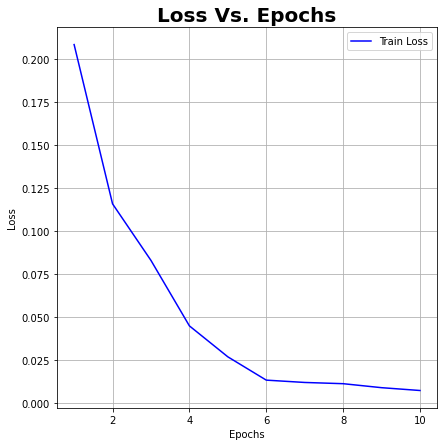

In [ ]:
create_plot_one_array(qa_train_loss_calc, 'Train Loss', 'Epochs', 'Loss', 'Loss Vs. Epochs', epoch = epochs)

# Sentiment Analysis Model

In [ ]:
# Randomize
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encoder_train = tokenizer.batch_encode_plus(sentiment_train_df.question.values, add_special_tokens = True, return_attention_masks = True, pad_to_max_length = True, max_length = 256, return_tensors = 'pt')

In [ ]:
encoder_dev = tokenizer.batch_encode_plus(sentiment_dev_df.question.values, add_special_tokens = True, return_attention_masks = True, pad_to_max_length = True, max_length = 256, return_tensors = 'pt')

In [ ]:
data_train = TensorDataset(encoder_train['input_ids'] , encoder_train["attention_mask"], torch.tensor(sentiment_train_df.answer.values))
data_dev = TensorDataset(encoder_dev['input_ids'], encoder_dev["attention_mask"], torch.tensor(sentiment_dev_df.answer.values))

#### Adding the model

In [ ]:
sa_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 20000, output_attentions = False, output_hidden_states = False).to(device)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
dataloader_train = DataLoader(data_train, sampler = RandomSampler(data_train), batch_size = 16)
print("dataloader_train len = ", len(dataloader_train))

dataloader_train len =  1000


In [ ]:
dataloader_dev = DataLoader(data_dev, sampler = RandomSampler(data_dev), batch_size = 32)
print("dataloader_dev len = ", len(dataloader_dev))

dataloader_dev len =  125


In [ ]:
def f1_score_func(preds,labels):
  preds_flat = np.argmax(preds,axis=1).flatten()
  labels_flat = labels.flatten()
  return f1_score(labels_flat,preds_flat,average = 'weighted')

In [ ]:
def accuracy(preds, labels):  
  preds_flat = np.argmax(preds,axis=1).flatten()
  labels_flat = labels.flatten()
  
  total = 0
  correct = 0

  for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]

    total += len(y_true)
    correct += len(y_preds[y_preds==label])
  acc = correct/total
  return acc

#### run the model

In [ ]:
def sa_test(model, dataloader_val):
  loss_val_total = 0
  
  for dev_data in dataloader_val:
    data = tuple(d.to(device) for d in dev_data)
    
    inputs = {'input_ids':  data[0], 'attention_mask':data[1], 'labels': data[2]}
    with torch.no_grad():
      outputs = model(**inputs)
        
    loss = outputs[0]
    loss_val_total += loss.item()
      
  loss_val_avg = loss_val_total/len(dataloader_val)  
  
  return loss_val_avg

In [ ]:
def sa_train(model, train_dataloader, dev_dataloader, log = 100, epoch = 10):
  print("Start training")
  train_iter = 0
  train_loss_array = []
  test_loss_array = []

  model.to(device)
  model.train()
  
  optimizer = AdamW(model.parameters(), lr = 1e-5, eps = 1e-8)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = len(train_dataloader) * epochs) #Later use train_dl

  for e in range(1, epoch+1):
    running_loss = 0.0
    train_loss = 0.0
    train_iter = 0
    
    print('\n======== Epoch {:} / {:} ========'.format(e, epochs))

    for train_data in train_dataloader:
      train_iter += 1
      model.zero_grad()
      data = tuple(t.to(device) for t in train_data)
      
      inputs = {"input_ids": data[0], "attention_mask": data[1], "labels": data[2]}
      outputs = model(**inputs)
      
      loss = outputs[0]
      loss.backward()
      
      torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)
      
      optimizer.step()
      scheduler.step()

      train_loss += loss.item()
      running_loss += loss.item()
      
      if train_iter % log == 0:
        print('Batch {:>5,}  of  {:>5,} Loss: {:.5f}' .format(train_iter , len(train_dataloader), running_loss / log))
        running_loss = 0.0 
    
    # calculate train loss for epoch
    train_loss_calc = train_loss / len(train_dataloader)
    train_loss_array.append(train_loss_calc)
    print('\n======== Epoch {:>3} Average Train Loss {:.5f} ========'.format(e, train_loss_calc))

    model.eval()
    dev_loss_calc = sa_test(model, dev_dataloader)
    test_loss_array.append(dev_loss_calc)
    print('\n======== Epoch {:>3} Average Dev Loss {:.5f} ========\n\n'.format(e, dev_loss_calc))
    model.train()
  
  print("Finish training")
  return model, train_loss_array, test_loss_array

In [ ]:
sa_trained_model ,sa_train_loss_calc, sa_dev_loss_calc = sa_train(sa_model, dataloader_train, dataloader_dev, log = 100, epoch = epochs)

Start training

======== Epoch 1 / 10 ========
Batch   100  of  1,000 Loss: 7.35727
Batch   200  of  1,000 Loss: 3.41132
Batch   300  of  1,000 Loss: 1.27428
Batch   400  of  1,000 Loss: 0.67937
Batch   500  of  1,000 Loss: 0.51683
Batch   600  of  1,000 Loss: 0.48875
Batch   700  of  1,000 Loss: 0.44810
Batch   800  of  1,000 Loss: 0.42447
Batch   900  of  1,000 Loss: 0.43564
Batch 1,000  of  1,000 Loss: 0.41530

======== Epoch   1 Average Train Loss 1.54513 ========

======== Epoch   1 Average Dev Loss 0.42540 ========



======== Epoch 2 / 10 ========
Batch   100  of  1,000 Loss: 0.33380
Batch   200  of  1,000 Loss: 0.32401
Batch   300  of  1,000 Loss: 0.33759
Batch   400  of  1,000 Loss: 0.32033
Batch   500  of  1,000 Loss: 0.32862
Batch   600  of  1,000 Loss: 0.32210
Batch   700  of  1,000 Loss: 0.34867
Batch   800  of  1,000 Loss: 0.30750
Batch   900  of  1,000 Loss: 0.31010
Batch 1,000  of  1,000 Loss: 0.32023

======== Epoch   2 Average Train Loss 0.32530 ========

======== Epo

### **Eval**

In [ ]:
def sa_eval(model ,dataloader_val):  
  predictions, true_vals = [],[]
  total = 0
  correct = 0
  for batch in dataloader_val:
    total += 1
    batch = tuple(b.to(device) for b in batch)
    
    inputs = {'input_ids':  batch[0], 'attention_mask':batch[1], 'labels': batch[2]}

    with torch.no_grad():
      outputs = model(**inputs)
        
    loss = outputs[0]
    logits = outputs[1]
    
    logits = logits.detach().cpu().numpy()
    label_ids = inputs['labels'].cpu().numpy()

    predictions.append(logits)
    true_vals.append(label_ids)

  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0) 

  acc = accuracy(predictions, true_vals)
  print('Accuracy of the network on the test images: {:.2f} %'.format(100*acc))

  test_score = f1_score_func(predictions, true_vals)
  print('\nF1 score of the network on the test images: {:.2f}'.format(test_score))

In [ ]:
sa_eval(sa_trained_model ,dataloader_dev)

Accuracy of the network on the test images: 83.35 %

F1 score of the network on the test images: 0.83


### **Plot - SA Model**

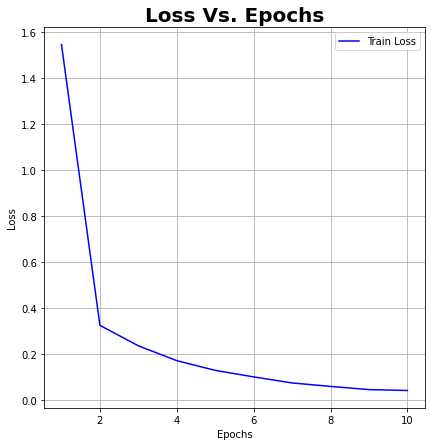

In [ ]:
create_plot_one_array(sa_train_loss_calc, 'Train Loss' , 'Epochs', 'Loss', 'Loss Vs. Epochs', epoch = epochs)

### **Plot - QA Model VS SA Model**

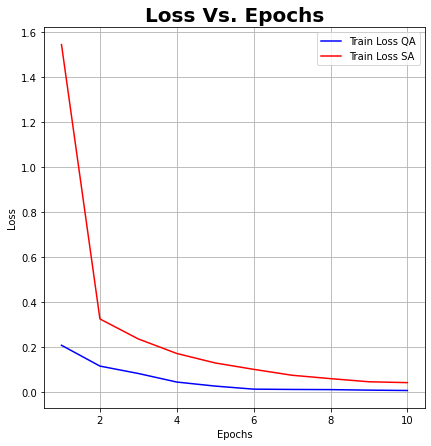

In [ ]:
create_plot(qa_train_loss_calc, sa_train_loss_calc, 'Train Loss QA', 'Train Loss SA', 'Epochs', 'Loss', 'Loss Vs. Epochs', epoch = epochs)